In [1]:
import numpy as np # np.array operations
import pandas as pd # pd.DataFrame operations, save / read csv
from skimage.io import imread # read images

%matplotlib inline
import matplotlib.pyplot as plt # plot images

from scipy.signal import convolve2d # filter images
from scipy.ndimage.interpolation import rotate # rotate images

# haralick features
from skimage import feature
from skimage.feature import greycomatrix
from skimage.feature import greycoprops
from scipy.stats import entropy
from skimage.feature import local_binary_pattern

# utility functions
# from sklearn.preprocessing import minmax_scale as mms
from skimage.util.shape import view_as_blocks
import scipy.stats as stats

# multiprocessing
from multiprocessing import Pool, Process, Array
import multiprocessing as mp

In [2]:
paths = pd.read_csv('../IC2017_DATA/valid_images.csv')
n_images = len(paths)

names_VI = ["ExG", "ExGR", "CIVE", "VEG", "WI", "NGRDI"]

## 1.2) BIC

In [3]:
def BIC(image, levels):
    """
    If blocks were 18 x 18 it would be easier to use the function in only the 16 x 16 core.
    """
    _all = np.zeros(levels * 2, dtype = int)
    border = _all[:levels]
    interior = _all[levels:]
    ns = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    
    lim_lin, lim_col = image.shape
    test = {-1, 16}

    for lin in range(lim_lin):
        for col in range(lim_col): # laço do elementos da matriz
            curr = image[lin, col]
            interior[curr] += 1
            for v, h in ns: # laço dos vizinhos
                nl = lin + v
                nc = col + h
                if nl not in test and nc not in test: # teste de estar dentro da matriz
                    if image[nl, nc] != curr:
                        border[curr] += 1
                        interior[curr] -=1
                        break

    # interior is always 16 * 16 - border
    return _all

## 1.3) Haralick

In [4]:
def entropy_func(P):
    return [entropy(P[:, :, 0, i].ravel()) for i in range(P.shape[3])]

In [5]:
def maxProb(P):
    return [np.max(P[:, :, 0, i]) for i in range(P.shape[3])]

In [6]:
def get_features(P):
    """
    Cada medida retorna 4 valores (1 para cada angulo).
    O valor 0 se refere ao fato de escolher sempre a mesma distância.
    """
    contrast = greycoprops(P, prop = "contrast")[0 , :]
    correlation = greycoprops(P, prop = "correlation")[0 , :]
    energy = greycoprops(P, prop = "ASM")[0 , :]
    homogeneity = greycoprops(P, prop = "homogeneity")[0 , :]
    _maxProb = maxProb(P)
    _entropy = entropy_func(P)
    
    #print(contrast, correlation, energy, homogeneity, _maxProb, _entropy)

    return [*contrast, *correlation, *energy, *homogeneity, *_maxProb, *_entropy]

# 1.4) Stats

In [7]:
def get_stats(b):
    return [np.min(b),
            np.percentile(b, .25), np.percentile(b, .5), np.percentile(b, .75),
            np.max(b), np.mean(b), np.std(b)]

In [8]:
# Features names

extractors = ["contrast", "correlation", "energy", "homogeneity", "maxprob", "entropy"]
angles = ["np.pi/4", "0", "3*np.pi/2", "7*np.pi/4"]
statistics = ["min", "q25", "q50", "q75", "max", "mean", "std"]

In [9]:
rotations = [
    (0, 0),
    (1, 15),
    (2, 30),
    (3, 45),
]

shifts = [
    (0, 0, 0),
    (1, 0, 1),
    (2, 1, 0),
    (3, 1, 1),
]

noises = [
    (0, 'None'),
    (1, 'Blur')
]

n = 9
kernel_blur = np.zeros((n, n), int)
kernel_blur[n // 2, :] = 1
kernel_blur = kernel_blur / kernel_blur.sum()

In [29]:
def transform_img(img, noise, rotation, shift):
    
    noise_num, noise_val = noise
    rot_num, rot_val = rotation
    sh_num, sh_val_v, sh_val_h = shift
    
    if len(img.shape) == 3: # check if it is pic instead of gt
        if noise_val == 'Blur':
            for c in range(3):
                img[:,:,c] = convolve2d(img[:,:,c], kernel_blur, mode = 'same', boundary = 'symm')
        # other filters can go below

        if rot_num != 0:
            img = np.pad(img, ((256, 256), (256, 256), (0, 0)), mode = 'reflect')
            img = rotate(img, rot_val, reshape = False)
            img = img[150 + 2 : 150 + 724 - 2, 150 + 2 : 150 + 724 - 2]
    else:
        if rot_num != 0:
            img = np.pad(img, ((256, 256), (256, 256)), mode = 'reflect')
            img = rotate(img, rot_val, reshape = False)
            img = img[150 + 2 : 150 + 724 - 2, 150 + 2 : 150 + 724 - 2]
            
    if sh_val_v == 1:
        img = img[8 : img.shape[0] - 8, :]
    if sh_val_h == 1:
        img = img[:, 8 : img.shape[1] - 8]
        
    return img

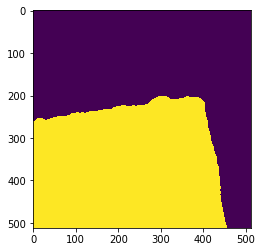

(0, 'None') (0, 0) (0, 0, 0) 32 32
(0, 'None') (0, 0) (1, 0, 1) 32 31
(0, 'None') (0, 0) (2, 1, 0) 31 32
(0, 'None') (0, 0) (3, 1, 1) 31 31
(0, 'None') (1, 15) (0, 0, 0) 45 45
(0, 'None') (1, 15) (1, 0, 1) 45 44
(0, 'None') (1, 15) (2, 1, 0) 44 45
(0, 'None') (1, 15) (3, 1, 1) 44 44
(0, 'None') (2, 30) (0, 0, 0) 45 45
(0, 'None') (2, 30) (1, 0, 1) 45 44
(0, 'None') (2, 30) (2, 1, 0) 44 45
(0, 'None') (2, 30) (3, 1, 1) 44 44
(0, 'None') (3, 45) (0, 0, 0) 45 45
(0, 'None') (3, 45) (1, 0, 1) 45 44
(0, 'None') (3, 45) (2, 1, 0) 44 45
(0, 'None') (3, 45) (3, 1, 1) 44 44
(1, 'Blur') (0, 0) (0, 0, 0) 32 32
(1, 'Blur') (0, 0) (1, 0, 1) 32 31
(1, 'Blur') (0, 0) (2, 1, 0) 31 32
(1, 'Blur') (0, 0) (3, 1, 1) 31 31
(1, 'Blur') (1, 15) (0, 0, 0) 45 45
(1, 'Blur') (1, 15) (1, 0, 1) 45 44
(1, 'Blur') (1, 15) (2, 1, 0) 44 45
(1, 'Blur') (1, 15) (3, 1, 1) 44 44
(1, 'Blur') (2, 30) (0, 0, 0) 45 45
(1, 'Blur') (2, 30) (1, 0, 1) 45 44
(1, 'Blur') (2, 30) (2, 1, 0) 44 45
(1, 'Blur') (2, 30) (3, 1, 1) 44 44


In [37]:
%%time
"""
This nested loop is to get the number of blocks each image will generate.
It is also good to test if everything makes sense.
"""

offset = 0
gt = imread(paths.iloc[50]['gt'], as_gray=True) # all valid images when read like this have a max value of 1.0
plt.imshow(gt)
plt.show()
for noise in noises:
    for rotation in rotations:
        for shift in shifts:
            _gt =  transform_img(gt.copy(), noise, rotation, shift)
            v = _gt.shape[0] // 16
            h = _gt.shape[1] // 16
            print(noise, rotation, shift, v, h)
            offset += v * h
            
BLKSPIMG = offset #  blocks per image
print('\n', 'BLKSPIMG:', offset, '\n')

In [30]:
def magic(data, offset, pic, gt, img_num, noise_num, rot_num, sh_num):
    
    def mms(X, a, b):
        _min = X.min()
        _max = X.max()
        X = (X - _min) / (_max - _min) if _min != _max else np.zeros_like(X)
        return X * (b - a) + a 

    v = gt.shape[0] // 16
    h = gt.shape[1] // 16

    B, G, R = [np.array(pic[:, :, c], float) for c in range(3)]
    total = R + G + B
    r = np.divide(R, total, out=np.zeros_like(total), where=total!=0)
    g = np.divide(G, total, out=np.zeros_like(total), where=total!=0)
    b = np.divide(B, total, out=np.zeros_like(total), where=total!=0)


    #VI generation
    F = {} # Imagens Filtradas
    F["ExG"] = 2 * g - r - b
    #print("ExGR")
    F["ExGR"] = F["ExG"] - 1.4 * r - g
    #print("CIVE")
    F["CIVE"] = 0.441 * r - 0.881 * g + 0.385 * b + 18.78745
    #print("VEG")
    divisor = 2 + r ** 0.667 * b ** (1 - 0.667)
    F["VEG"] = np.divide(g, divisor, out=np.zeros_like(divisor), where=divisor!=0)
    #print("WI")
    divisor = r - g
    F["WI"] = np.divide((g - b), divisor, out=np.zeros_like(divisor), where=divisor!=0)
    #print("NGRDI")
    divisor = G + R
    F["NGRDI"] = np.divide((G - R), divisor, out=np.zeros_like(divisor), where=divisor!=0)

    N = {f : mms(F[f], 0, 8 - .001).astype(int) for f in F} # Imagens filtradas Normalizadas


    #Haralick
    for ix, f in enumerate(names_VI):
        blocks = view_as_blocks(N[f], (16,16)).reshape((v * h, 16, 16))
        for j, b in enumerate(blocks):
            # b = np.array(mms(b, (0.5,7.5)) , dtype="uint8") # normaliza apenas o bloco
            P = greycomatrix(b, [1], (np.pi/4, 0, 3*np.pi/2, 7*np.pi/4), 8)
    #         VI[f][offset + j, :24] = get_features(P)
            data[offset + j, ix * 24 : (ix + 1) * 24] = get_features(P)

    #"STATS"
    for ix, f in enumerate(names_VI):
        blocks = view_as_blocks(F[f], (16,16)).reshape((v * h, 16, 16))
        for j, b in enumerate(blocks):
    #         VI[f][offset + j, 24:] = get_stats(b)
            data[offset + j, 144 + ix * 7 : 144 + (ix + 1) * 7] = get_stats(b)

    #BIC
    bic_pic = sum(mms(pic[:, :, c], 0, 4 - .001).astype(int) * (4**c) for c in range(3))
    blocks = view_as_blocks(bic_pic, (16,16)).reshape((v * h, 16, 16))
    for j, b in enumerate(blocks):
    #     bic[offset + j, 0:64], bic[b, 64:64*2] = BIC(b, 64)
        data[offset + j, 186 : 186 + 128] = BIC(b, 64)

    #GT
    blocks = view_as_blocks(gt, (16,16)).reshape((v * h, 16, 16))
    for j, b in enumerate(blocks):
        data[offset + j, -7 : -1] = (b > .5).mean() > .5, img_num, noise_num, rot_num, sh_num, j

# Laço de criação das Features

In [31]:
features_count = np.array([
    6 * 24, # haralick
    6 * 7, # stats
    64 + 64, # bic
    7 # extra: target, img_num, noise_num, rot_num, sh_num, block_num, base_num
])

In [32]:
col_names = []

for f in names_VI:
    for ext in extractors:
        for ang in angles:
            col_names.append("%s_%s_%s" % (f, ext, ang))
            
for f in names_VI:
    for s in statistics:
        col_names.append("%s_%s" % (f, s))

for i in range(64):
    col_names.append("border_%d" % (i))
    
for i in range(64):
    col_names.append("interior_%d" % (i))
    
col_names.extend(['target', 'img_num', 'noise_num', 'rot_num', 'sh_num', 'block_num', 'base_num'])

len(col_names)

321

In [33]:
n_features = int(features_count.sum())
print(features_count.cumsum())

[144 186 314 321]


In [34]:
data_shape = (n_images * BLKSPIMG,  n_features)
data_shape

(3272376, 321)

In [35]:
shared_data = Array('d', n_images * BLKSPIMG * n_features, lock=False)
# QUESITON: always initialize with 0 ?

In [36]:
data = np.frombuffer(shared_data).reshape(data_shape)
data.sum()

0.0

In [39]:
def worker(args):

    i, img_num, path_pic, path_gt = args
    offset = i * BLKSPIMG    
    pic = imread(path_pic, False)[:, :, : 3]
    gt = imread(path_gt, as_gray=True) # all valid images when read like this have a max value of 1.0
    data = np.frombuffer(shared_data).reshape(data_shape)
    
    for noise in noises:
        for rotation in rotations:
            for shift in shifts:
                _pic = transform_img(pic.copy(), noise, rotation, shift)
                _gt =  transform_img(gt.copy(), noise, rotation, shift)
                magic(data, offset, _pic, _gt, img_num, noise[0], rotation[0], shift[0])
                v = _gt.shape[0] // 16
                h = _gt.shape[1] // 16
                offset += v * h

In [41]:
"""
This function is required to use the shared variables as global variables in the shared enviroment.
"""
def _init(init_args):
#     global shared_array
    shared_array = init_args[0]

In [42]:
"""
Define pool of processes
"""
pool = Pool(processes=7, initializer=_init, initargs=([shared_data],))

/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/skimage/util/shape.py:94: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/skimage/util/shape.py:94: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/skimage/util/shape.py:94: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/skimage/util/shape.py:94: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
/store/tveiga/minico

In [43]:
%%time
"""
Execute pool of processes
"""
pool.map(worker, ((
    i,
    paths['num'].iloc[i],
    paths['pic'].iloc[i],
    paths['gt'].iloc[i]
) for i in range(min(n_images, 70))));

CPU times: user 1.44 s, sys: 547 ms, total: 1.99 s
Wall time: 1h 3min 22s


In [45]:
data = np.frombuffer(shared_data).reshape(data_shape)

In [46]:
# First sanity check
print(data[12 * BLKSPIMG :, -7].mean(), data[: 12 * BLKSPIMG, -7].mean())

0.5482735974417755 0.8620035819029761


In [47]:
df = pd.DataFrame(data, columns=col_names)

In [49]:
df['base_num'] = 1
df.loc[df.img_num <= 17, 'base_num'] = 0
df.loc[df.img_num >= 40, 'base_num'] = 2

# More verifications

In [50]:
df.base_num.unique()

array([0, 1, 2])

In [74]:
img = 49
noise = 1
rot = 3
shift = 1
X = df.query('img_num == @img and noise_num == @noise and rot_num == @rot and sh_num == @shift')
gt = X['target']
rot_num, rot_val = rotations[rot]
sh_num, sh_val_v, sh_val_h = shifts[shift]

In [75]:
if sh_val_v != sh_val_h:
    x = (-1 + np.sqrt(1 + 4 * len(gt))) / 2
    x = int(x)
    if sh_val_h:
        a, b = x + 1, x
    else:
        a, b = x, x + 1
else:
    a = b = int(np.sqrt(len(gt)))
a, b

(45, 44)

(720, 704)

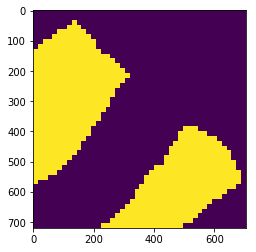

In [76]:
curr = gt.values.reshape(a, b)
curr = np.repeat(curr, 16, axis = 0)
curr = np.repeat(curr, 16, axis = 1)
plt.imshow(curr)
curr.shape

# Saving

In [77]:
%%time
df.to_csv('../IC2017_DATA/augmented_2.csv', index = False)

CPU times: user 9min 56s, sys: 13.2 s, total: 10min 10s
Wall time: 10min 16s
